In [1]:
import os
notebook_wd = os.getcwd()

In [2]:
from datetime import date
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [3]:
os.chdir(os.path.join(notebook_wd, '..'))
from src.d00_utils.conf_utils import *

In [4]:
compounds, water = load_compounds()
exp_params = load_experiments(['bd_wet', 'bd_dry', 'bd_nacl_low', 'bd_nacl_high','bd_na2so4_low', 'bd_na2so4_high'])
constants = load_constants()
paths = load_paths()
exp_params

{'bd_wet': {'raw_data_file': '190918-butenedial-droplets.csv',
  'composition': {'PEG-6': 0.2, 'Butenedial': 0.075},
  'solution_name': 'bd10hg20_002',
  'idx_range': [16, 500],
  'bad_idx': None,
  'trap_time': [2, 300],
  'other_query': '(rh>50 or trapped<5) and comp=="bd10hg20_002"',
  'y_col': 'mz85_mz283',
  'p283_cutoff': 1000,
  'columns_to_keep': ['trapped', 'comp', 'experiment', 'mz85_mz283'],
  'number_of_steps': 3000.0,
  'r_init': 1.29e-05,
  'T': 300.1,
  'RH': 0.75,
  'x_water': 0.795,
  'value_idx': 0,
  'norm_idx': 1,
  'cal_data_time': 5,
  'label': 'BD (wet)'},
 'bd_dry': {'raw_data_file': '190918-butenedial-droplets.csv',
  'composition': {'Butenedial': 0.075, 'PEG-6': 0.2},
  'solution_name': 'bd10hg20_008',
  'idx_range': [63, 500],
  'bad_idx': [113],
  'trap_time': [2, 50],
  'other_query': 'rh<20 and comp=="bd10hg20_008"',
  'y_col': 'mz85_mz283',
  'p283_cutoff': 1000,
  'columns_to_keep': ['trapped', 'comp', 'experiment', 'mz85_mz283'],
  'number_of_steps': 30

In [5]:
from src.d01_data.clean_ms_data import *

df_cleaned = filter_and_clean_data(paths['raw_data'], exp_params, save_cleaned_data=True)
df_cleaned.experiment.unique()

array(['bd_wet', 'bd_dry', 'bd_nacl_low', 'bd_nacl_high', 'bd_na2so4_low',
       'bd_na2so4_high'], dtype=object)

In [6]:
from src.d01_data.process_ms_data import *

df_processed = process_ms_data_in_evap_experiments(paths['cleaned_data'], exp_params, save_processed_data=True)
df_processed.head()

C:\Users\joh3146\Documents\droplet-chemistry\src\d01_data\process_ms_data.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df_experiment[cal_data_col] = df_experiment[experiment_defs['y_col']] * cal_factor_avg
C:\Users\joh3146\Documents\droplet-chemistry\src\d01_data\process_ms_data.py:110: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df_experiment[cal_data_col + '_std'] = df_experiment[cal_data_col] * cal_factor_std
C:\Users\joh3146\Documents\droplet-chemistry\src\d01_data\process_ms_data.py:114: SettingWithCopyWarning: 
A value is t

,hrs,solution_name,experiment,mz85_mz283,mol85_mol283,mol85_mol283_std,mol85_mol283/mol85_mol283_0
0,4.200000,bd10hg20_002,bd_wet,0.007122,0.090733,0.000113,0.241953
1,2.800000,bd10hg20_002,bd_wet,0.007784,0.099165,0.000123,0.264441
2,2.883333,bd10hg20_002,bd_wet,0.009940,0.126630,0.000157,0.337680
3,0.433333,bd10hg20_002,bd_wet,0.025973,0.330885,0.000410,0.882360
4,0.700000,bd10hg20_002,bd_wet,0.024839,0.316434,0.000393,0.843825


In [29]:
from src.d02_extraction.cluster_ms_data import *

df_clustered = create_clustered_statistics_dataframe(paths['processed_data'], 'hrs', ['mol85_mol283'], 
                                                     max_points_per_cluster=4, save_clustered_data=True)

df_clustered.head()

,mol85_mol283,hrs,mol85_mol283_std,hrs_std,experiment
0,0.374519,0.195833,0.045142,0.197755,bd_wet
1,0.236034,0.996667,0.062729,0.281711,bd_wet
2,0.138385,2.716667,0.046233,0.220479,bd_wet
3,0.212267,1.838889,0.004626,0.113448,bd_wet
4,0.090733,4.200000,NaN,NaN,bd_wet


In [30]:
from src.d03_modeling.conduct_linear_regression import *
df_mod = create_ordinary_least_squares_data(paths['clustered_data'], x_col_name='hrs', y_col_name='mol85_mol283',
                                        take_log=True, save_data=False, experiment='bd_wet')
df_mod.head()

,hrs,mol85_mol283,score,tau
0,0.195833,0.348493,0.976652,2.909448
1,0.236279,0.343682,0.976652,2.909448
2,0.276726,0.338938,0.976652,2.909448
3,0.317172,0.334258,0.976652,2.909448
4,0.357618,0.329644,0.976652,2.909448


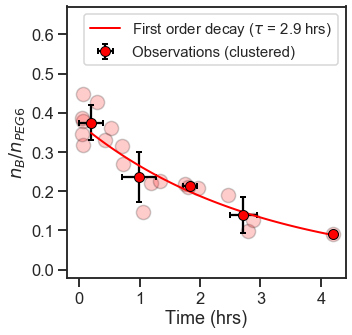

In [32]:
# created a new plotting function
from src.d05_reporting.plot_ms_data import plot_ms_data


fig, ax = plt.subplots(figsize=(5,5))
ax = plot_ms_data(df_data=df_processed[df_processed.experiment == 'bd_wet'], x_data_col='hrs', y_data_cols=['mol85_mol283'],
             series_labels=['Observations'], series_colors=['red'], save_fig=False, ax=ax,
             df_model=df_mod, x_model_col='hrs', y_model_cols=['mol85_mol283'], 
             model_label='First order decay ($\\tau$ = %.1f hrs)' % df_mod.tau[0],
             df_cluster=df_clustered[df_clustered.experiment == 'bd_wet'], x_cluster_col='hrs', y_cluster_cols=['mol85_mol283'],
             x_label='hrs', y_label='$n_{B} / n_{PEG6}$', series_title=None)

In [ ]:
plot_ms_data(df_data=df_processed[df_processed.experiment == 'bd_na2so4_high'], x_data_col='hrs', y_data_cols=['mol85_mol283'],
             series_labels=['Butenedial'], series_colors=['red'], save_fig=False,
             df_model=None, x_model_col=None, y_model_cols=None,
             df_cluster=df_clustered[df_clustered.experiment == 'bd_na2so4_high'], x_cluster_col='hrs', y_cluster_cols=['mol85_mol283'],
             x_label=None, y_label=None, series_title=None)